In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [3]:
df = pd.read_csv("C:/Users/hetpa/Downloads/Churn_Modelling (1).csv")
df.shape

(10000, 14)

In [4]:
# Check columns list and missing values
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [5]:
# Get unique count for each variable
df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

From the above, we will not require the first 2 attributes as the are specific to a customer. It is borderline with the surname as this would result to profiling so we exclude this as well.



In [6]:
# Drop the columns as explained above
df = df.drop(["RowNumber", "CustomerId", "Surname"], axis = 1)

In [8]:
df.head()

CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42       2       0.00              1   
1          608     Spain  Female   41       1   83807.86              1   
2          502    France  Female   42       8  159660.80              3   
3          699    France  Female   39       1       0.00              2   
4          850     Spain  Female   43       2  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0          1               1        101348.88       1  
1          0               1        112542.58       0  
2          1               0        113931.57       1  
3          0               0         93826.63       0  
4          1               1         79084.10       0

There are some questions that arise from the information given. The data seems to be a snapshot of a specific date, but it's not clear what that date is or why it's relevant. It would be useful to have access to balances over a period of time instead of just one date. Some customers have exited but still have a balance in their account, which could mean they have left a specific product but not the bank as a whole. The definition of an "active member" is unclear, and it would be helpful to know if there are different levels of activity. Providing transaction counts in terms of both credits and debits could be more informative than just listing the number of products a customer has. Finally, it's important to acknowledge that modeling without context may lead to less accurate results, but for this exercise, we will proceed without it.

In [9]:
df.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [10]:
# Define function to remove outliers
def remove_outliers(df, cols, distance=1.5):
    Q1 = df[cols].quantile(0.25)
    Q3 = df[cols].quantile(0.75)
    IQR = Q3 - Q1
    condition = ~((df[cols] < (Q1 - distance * IQR)) | (df[cols] > (Q3 + distance * IQR))).any(axis=1)
    filtered_df = df[condition]
    return filtered_df

# Define columns to check for outliers
cols_to_check = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']


# Remove outliers
df_filtered = remove_outliers(df, cols_to_check)

# Print number of outliers removed
print('Number of outliers removed:', df.shape[0] - df_filtered.shape[0])

Number of outliers removed: 432


In [11]:
df = df_filtered

In [12]:
df.shape

(9568, 11)

# Data Analysis

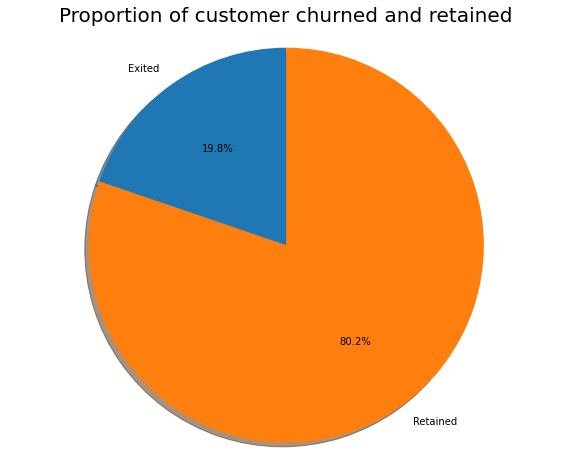

In [13]:
labels = 'Exited', 'Retained'
sizes = [df.Exited[df['Exited']==1].count(), df.Exited[df['Exited']==0].count()]
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of customer churned and retained", size = 20)
plt.show()

If 20% of customers have already left, a basic model would be to assume that 20% of the remaining customers will also leave. However, since 20% is a relatively small number, it's important to choose a model that can accurately predict this group of customers. This is because the bank wants to focus on identifying and keeping these customers rather than accurately predicting which customers will stay.

<AxesSubplot:xlabel='IsActiveMember', ylabel='count'>

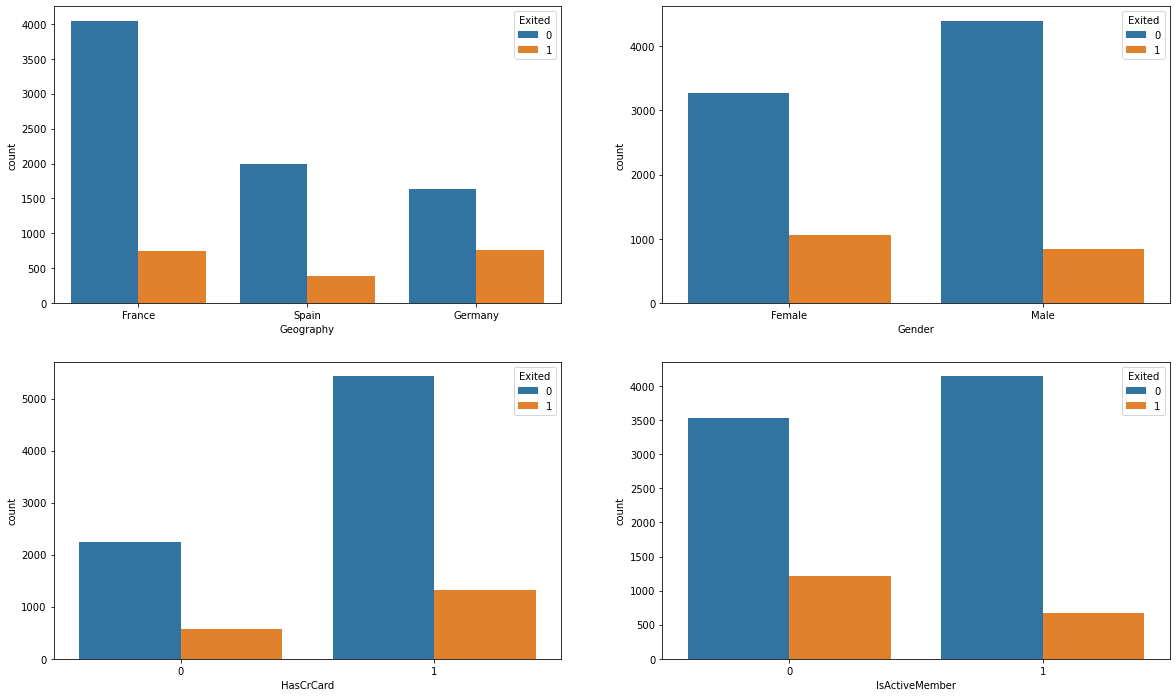

In [14]:
# We first review the 'Status' relation with categorical variables
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.countplot(x='Geography', hue = 'Exited',data = df, ax=axarr[0][0])
sns.countplot(x='Gender', hue = 'Exited',data = df, ax=axarr[0][1])
sns.countplot(x='HasCrCard', hue = 'Exited',data = df, ax=axarr[1][0])
sns.countplot(x='IsActiveMember', hue = 'Exited',data = df, ax=axarr[1][1])

1- Although most of the data comes from customers in France, the proportion of churned customers is not directly related to the population of customers in each area. This suggests that the bank may have an issue in areas with fewer clients, such as not allocating enough customer service resources.

2- Female customers have a higher proportion of churn than male customers.

3- Interestingly, most of the customers who churned are those with credit cards. However, since most of the customers also have credit cards, it is uncertain whether this is just a coincidence.

4- As expected, inactive members are more likely to churn. However, the proportion of inactive members is quite high, which is a cause for concern. The bank may need to implement a program to engage this group and turn them into active customers, which could positively impact the customer churn rate.

<AxesSubplot:xlabel='Exited', ylabel='EstimatedSalary'>

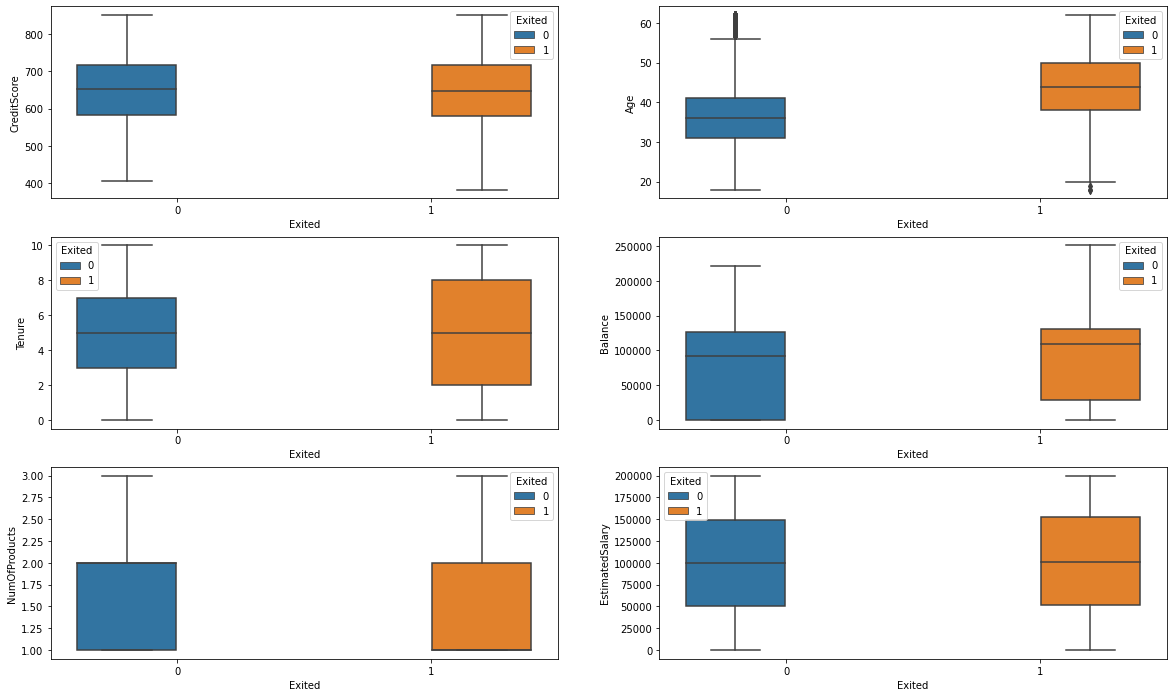

In [15]:
# Relations based on the continuous data attributes
fig, axarr = plt.subplots(3, 2, figsize=(20, 12))
sns.boxplot(y='CreditScore',x = 'Exited', hue = 'Exited',data = df, ax=axarr[0][0])
sns.boxplot(y='Age',x = 'Exited', hue = 'Exited',data = df , ax=axarr[0][1])
sns.boxplot(y='Tenure',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][0])
sns.boxplot(y='Balance',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][1])
sns.boxplot(y='NumOfProducts',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][0])
sns.boxplot(y='EstimatedSalary',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][1])



There is no significant difference in credit score distribution between customers who stay and those who leave.

Older customers are more likely to churn than younger ones, suggesting that there may be differences in service preferences among age groups. The bank may need to review its target market or retention strategies for different age groups.

Customers with either very short or very long tenure are more likely to churn than those with average tenure.

The bank is losing customers with significant bank balances, which could impact their available capital for lending.

Neither the product nor salary has a significant effect on the likelihood of churn.

# Split Train, test data

In [16]:
df_train = df.sample(frac=0.8,random_state=200)
df_test = df.drop(df_train.index)
print(len(df_train))
print(len(df_test))

7654
1914


In [17]:
df_train.describe()

CreditScore          Age      Tenure        Balance  NumOfProducts  \
count  7654.000000  7654.000000  7654.00000    7654.000000    7654.000000   
mean    651.626862    37.669454     5.02613   77101.123155       1.513718   
std      95.933786     8.751425     2.88421   62316.705914       0.548457   
min     386.000000    18.000000     0.00000       0.000000       1.000000   
25%     584.000000    31.000000     3.00000       0.000000       1.000000   
50%     653.000000    37.000000     5.00000   97830.040000       1.000000   
75%     718.000000    43.000000     7.00000  127859.542500       2.000000   
max     850.000000    62.000000    10.00000  238387.560000       3.000000   

         HasCrCard  IsActiveMember  EstimatedSalary       Exited  
count  7654.000000     7654.000000      7654.000000  7654.000000  
mean      0.703162        0.501698     99965.953874     0.195584  
std       0.456894        0.500030     57523.006655     0.396676  
min       0.000000        0.000000        11.580000     0.000000  
25%       0.000000        0.000000     50901.595000     0.000000  
50%       1.000000        1.000000     99521.715000     0.000000  
75%       1.000000        1.000000    149295.360000     0.000000  
max       1.000000        1.000000    199992.480000     1.000000

(-1.0, 5.0)

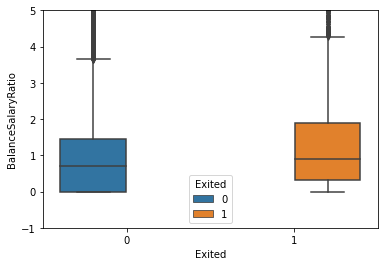

In [18]:
df_train['BalanceSalaryRatio'] = df_train.Balance/df_train.EstimatedSalary
sns.boxplot(y='BalanceSalaryRatio',x = 'Exited', hue = 'Exited',data = df_train)
plt.ylim(-1, 5)

Although salary does not have a significant impact on the likelihood of customer churn, the ratio of bank balance to estimated salary indicates that customers with a higher balance salary ratio are more likely to churn. This is concerning for the bank because it could impact their source of loan capital.

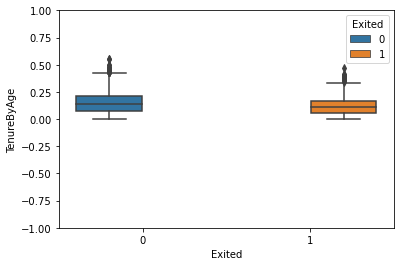

In [19]:
# Given that tenure is a 'function' of age, we introduce a variable aiming to standardize tenure over age:
df_train['TenureByAge'] = df_train.Tenure/(df_train.Age)
sns.boxplot(y='TenureByAge',x = 'Exited', hue = 'Exited',data = df_train)
plt.ylim(-1, 1)
plt.show()

"Finally, we add a new variable that considers credit score in relation to age, in order to account for how credit behavior may change throughout adulthood."


In [20]:
df_train['CreditScoreGivenAge'] = df_train.CreditScore/(df_train.Age)

In [21]:
df_train


CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
2189          480    France    Male   35       2  165692.91              1   
8716          565    France    Male   38       5       0.00              2   
666           559    France  Female   31       3  127070.73              1   
445           748    France  Female   26       1   77780.29              1   
3138          756    France    Male   60       2       0.00              1   
6254          578   Germany    Male   37       1  135650.88              1   
6258          712    France  Female   27       2  133009.51              1   
9858          507   Germany    Male   40       3  120105.43              1   
1379          668   Germany  Female   32      10   92041.87              1   
7298          620    France    Male   28       9   71902.52              1   
2216          686    France  Female   47       5  113328.93              1   
8800          691    France    Male   37       9  149405.18              1   
6788          825   Germany    Male   37       6  118050.79              1   
2928          668   Germany  Female   39       0  122104.79              1   
5994          580   Germany    Male   35      10  136281.41              2   
8546          553   Germany    Male   35       2  158584.28              2   
3654          542   Germany    Male   33       8  142871.27              2   
6582          525     Spain  Female   60       7       0.00              2   
3427          465    France    Male   41       9  117221.15              1   
6284          596    France    Male   33       8       0.00              1   
5344          787    France    Male   25       5       0.00              2   
1308          710    France    Male   33      10  118327.17              2   
6303          788   Germany  Female   49       4  137455.99              1   
8882          731     Spain  Female   39       2       0.00              2   
2007          705   Germany  Female   43      10  146547.78              1   
8494          671   Germany    Male   36       2  116695.27              1   
606           699    France    Male   53       4       0.00              2   
4837          803    France    Male   28       3       0.00              2   
6053          552     Spain    Male   42       4       0.00              2   
5076          700    France  Female   37       7       0.00              2   
1242          696   Germany    Male   30       4  114027.70              1   
4093          764     Spain  Female   48       1   75990.97              1   
6018          731    France    Male   30       7       0.00              2   
7256          821   Germany  Female   31       2   68927.57              1   
4601          642   Germany    Male   30       8  134497.27              1   
8043          720     Spain    Male   31       4  141356.47              1   
4862          645     Spain  Female   55       1  133676.65              1   
1749          552    France    Male   42       9  133701.07              2   
114           721   Germany    Male   28       9  154475.54              2   
5876          704    France    Male   39       2  111525.02              1   
5534          658    France  Female   29       8       0.00              2   
124           625    France  Female   28       3       0.00              1   
4221          701   Germany    Male   23       5  186101.18              2   
7042          544    France    Male   44       1       0.00              2   
7797          502   Germany    Male   33       5  174673.65              2   
5158          587    France    Male   55       9       0.00              1   
5893          605     Spain  Female   48      10  150315.92              1   
2889          594    France  Female   31       9       0.00              1   
3165          651    France  Female   39       6       0.00              1   
4080          808   Germany  Female   37       2  100431.84              1   
8501          678     Spain 

#  Data preperation for model fitting

In [22]:
# Arrange columns by data type for easier manipulation
continuous_vars = ['CreditScore',  'Age', 'Tenure', 'Balance','NumOfProducts', 'EstimatedSalary', 'BalanceSalaryRatio',
                   'TenureByAge','CreditScoreGivenAge']
cat_vars = ['HasCrCard', 'IsActiveMember','Geography', 'Gender']
df_train = df_train[['Exited'] + continuous_vars + cat_vars]
df_train.head()

Exited  CreditScore  Age  Tenure    Balance  NumOfProducts  \
2189       0          480   35       2  165692.91              1   
8716       0          565   38       5       0.00              2   
666        0          559   31       3  127070.73              1   
445        0          748   26       1   77780.29              1   
3138       1          756   60       2       0.00              1   

      EstimatedSalary  BalanceSalaryRatio  TenureByAge  CreditScoreGivenAge  \
2189        197984.58            0.836898     0.057143            13.714286   
8716         80630.32            0.000000     0.131579            14.868421   
666         160941.78            0.789545     0.096774            18.032258   
445         183049.41            0.424914     0.038462            28.769231   
3138        166513.49            0.000000     0.033333            12.600000   

      HasCrCard  IsActiveMember Geography  Gender  
2189          1               1    France    Male  
8716          0               1    France    Male  
666           0               1    France  Female  
445           0               1    France  Female  
3138          1               1    France    Male

"We modify the one-hot encoded variables by replacing the value 0 with -1. This allows the models to recognize a negative relationship when the attribute is not applicable, rather than interpreting it as having a value of 0."

In [23]:
df_train.loc[df_train.HasCrCard == 0, 'HasCrCard'] = -1
df_train.loc[df_train.IsActiveMember == 0, 'IsActiveMember'] = -1
df_train.head()

Exited  CreditScore  Age  Tenure    Balance  NumOfProducts  \
2189       0          480   35       2  165692.91              1   
8716       0          565   38       5       0.00              2   
666        0          559   31       3  127070.73              1   
445        0          748   26       1   77780.29              1   
3138       1          756   60       2       0.00              1   

      EstimatedSalary  BalanceSalaryRatio  TenureByAge  CreditScoreGivenAge  \
2189        197984.58            0.836898     0.057143            13.714286   
8716         80630.32            0.000000     0.131579            14.868421   
666         160941.78            0.789545     0.096774            18.032258   
445         183049.41            0.424914     0.038462            28.769231   
3138        166513.49            0.000000     0.033333            12.600000   

      HasCrCard  IsActiveMember Geography  Gender  
2189          1               1    France    Male  
8716         -1               1    France    Male  
666          -1               1    France  Female  
445          -1               1    France  Female  
3138          1               1    France    Male

In [24]:
# One hot encode the categorical variables
lst = ['Geography', 'Gender']
remove = list()
for i in lst:
    if (df_train[i].dtype == np.str or df_train[i].dtype == np.object):
        for j in df_train[i].unique():
            df_train[i+'_'+j] = np.where(df_train[i] == j,1,-1)
        remove.append(i)
df_train = df_train.drop(remove, axis=1)
df_train.head()

C:\Users\hetpa\AppData\Local\Temp\ipykernel_17376\366624441.py:5: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (df_train[i].dtype == np.str or df_train[i].dtype == np.object):
C:\Users\hetpa\AppData\Local\Temp\ipykernel_17376\366624441.py:5: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (df_train[i].dtype == np.str or df_train[i].dtype == np.object):
C:\Users\hetpa\AppData\Local\Temp\ipykernel_17376\36662444

Exited  CreditScore  Age  Tenure    Balance  NumOfProducts  \
2189       0          480   35       2  165692.91              1   
8716       0          565   38       5       0.00              2   
666        0          559   31       3  127070.73              1   
445        0          748   26       1   77780.29              1   
3138       1          756   60       2       0.00              1   

      EstimatedSalary  BalanceSalaryRatio  TenureByAge  CreditScoreGivenAge  \
2189        197984.58            0.836898     0.057143            13.714286   
8716         80630.32            0.000000     0.131579            14.868421   
666         160941.78            0.789545     0.096774            18.032258   
445         183049.41            0.424914     0.038462            28.769231   
3138        166513.49            0.000000     0.033333            12.600000   

      HasCrCard  IsActiveMember  Geography_France  Geography_Germany  \
2189          1               1                 1                 -1   
8716         -1               1                 1                 -1   
666          -1               1                 1                 -1   
445          -1               1                 1                 -1   
3138          1               1                 1                 -1   

      Geography_Spain  Gender_Male  Gender_Female  
2189               -1            1             -1  
8716               -1            1             -1  
666                -1           -1              1  
445                -1           -1              1  
3138               -1            1             -1

Machine learning scaling is part of data preparation as this technique brings data points that are far from each other closer in order to increase the algorithm effectiveness and speed up the Machine Learning processing. Scaling data enables the model to learn and actually understand the problem.

In [25]:
# minMax scaling the continuous variables
minVec = df_train[continuous_vars].min().copy()
maxVec = df_train[continuous_vars].max().copy()
df_train[continuous_vars] = (df_train[continuous_vars]-minVec)/(maxVec-minVec)
df_train.head()

Exited  CreditScore       Age  Tenure   Balance  NumOfProducts  \
2189       0     0.202586  0.386364     0.2  0.695057            0.0   
8716       0     0.385776  0.454545     0.5  0.000000            0.5   
666        0     0.372845  0.295455     0.3  0.533043            0.0   
445        0     0.780172  0.181818     0.1  0.326277            0.0   
3138       1     0.797414  0.954545     0.2  0.000000            0.0   

      EstimatedSalary  BalanceSalaryRatio  TenureByAge  CreditScoreGivenAge  \
2189         0.989960            0.000079     0.102857             0.164835   
8716         0.403132            0.000000     0.236842             0.193890   
666          0.804728            0.000074     0.174194             0.273539   
445          0.915277            0.000040     0.069231             0.543841   
3138         0.832589            0.000000     0.060000             0.136783   

      HasCrCard  IsActiveMember  Geography_France  Geography_Germany  \
2189          1               1                 1                 -1   
8716         -1               1                 1                 -1   
666          -1               1                 1                 -1   
445          -1               1                 1                 -1   
3138          1               1                 1                 -1   

      Geography_Spain  Gender_Male  Gender_Female  
2189               -1            1             -1  
8716               -1            1             -1  
666                -1           -1              1  
445                -1           -1              1  
3138               -1            1             -1

This code defines a function called DfPrepPipeline that prepares a pandas DataFrame (df_predict) for use as input to a machine learning model. The function performs several data preparation steps on df_predict to ensure it has the same structure and scaling as the training data used to train the model.

The function first adds three new features to the df_predict DataFrame: BalanceSalaryRatio, TenureByAge, and CreditScoreGivenAge. These features are calculated based on the existing columns in the DataFrame.

Next, the columns of the df_predict DataFrame are reordered such that the target variable, Exited, comes first, followed by the continuous variables, and then the categorical variables. The categorical variables are converted to numerical variables by replacing 0 values with -1.

The function then performs one-hot encoding on the Geography and Gender categorical variables by creating new columns for each unique value in these variables. The new columns are binary variables, taking a value of 1 if the original value matches the new column's value and -1 otherwise.


We are replacing 0 with -1 to avoid creating a bias towards 0 which could affect the performance of some algorithms 

Finally, the continuous variables are scaled using the minimum and maximum values from the training data. The df_predict DataFrame is then ordered to match the order of columns in the training data before being returned by the function.

In summary, this function applies several data preparation steps to ensure that a given DataFrame matches the structure and scaling of the training data used to train a machine learning model.

In [26]:
def DfPrepPipeline(df_predict, df_train_Cols, minVec, maxVec):
    # Add new features
    df_predict['BalanceSalaryRatio'] = df_predict.Balance/df_predict.EstimatedSalary
    df_predict['TenureByAge'] = df_predict.Tenure/(df_predict.Age - 18)
    df_predict['CreditScoreGivenAge'] = df_predict.CreditScore/(df_predict.Age - 18)
    # Reorder the columns
    continuous_vars = ['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary','BalanceSalaryRatio',
                   'TenureByAge','CreditScoreGivenAge']
    cat_vars = ['HasCrCard','IsActiveMember',"Geography", "Gender"] 
    df_predict = df_predict[['Exited'] + continuous_vars + cat_vars]
    # Change the 0 in categorical variables to -1
    df_predict.loc[df_predict.HasCrCard == 0, 'HasCrCard'] = -1
    df_predict.loc[df_predict.IsActiveMember == 0, 'IsActiveMember'] = -1
    # One hot encode the categorical variables
    lst = ["Geography", "Gender"]
    remove = list()
    for i in lst:
        for j in df_predict[i].unique():
            df_predict[i+'_'+j] = np.where(df_predict[i] == j,1,-1)
        remove.append(i)
    df_predict = df_predict.drop(remove, axis=1)
    # Ensure that all one hot encoded variables that appear in the train data appear in the subsequent data
    L = list(set(df_train_Cols) - set(df_predict.columns))
    for l in L:
        df_predict[str(l)] = -1        
    # MinMax scaling coontinuous variables based on min and max from the train data
    df_predict[continuous_vars] = (df_predict[continuous_vars]-minVec)/(maxVec-minVec)
    # Ensure that The variables are ordered in the same way as was ordered in the train set
    df_predict = df_predict[df_train_Cols]
    return df_predict

In [43]:
# Check the imbalance in the dataset
print(df_train.Exited.value_counts())

0    6157
1    1497
Name: Exited, dtype: int64


In [27]:
# Support functions
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform

# Fit models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Scoring functions
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [28]:
 #Function to give best model score and parameters
def best_model(model):
    print(model.best_score_)    
    print(model.best_params_)
    print(model.best_estimator_)
def get_auc_scores(y_actual, method,method2):
    auc_score = roc_auc_score(y_actual, method); 
    fpr_df, tpr_df, _ = roc_curve(y_actual, method2); 
    return (auc_score, fpr_df, tpr_df)

We balance the data using class weights to account for imbalanced classes in the dataset. Imbalanced classes refer to cases where the number of observations in each class is significantly different. In such cases, the model may be biased towards the majority class and may have lower accuracy on the minority class. By balancing the data with class weights, we assign higher weights to the minority class, allowing the model to give equal importance to both classes during training. This can lead to better performance on the minority class and overall better model performance.

In [50]:
# Calculate class weights
from sklearn.utils import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(df_train.Exited), y=df_train.Exited)

# Fit logistic regression with class weights
log_weighted = LogisticRegression(class_weight={0:class_weights[0], 1:class_weights[1]})
log_weighted.fit(df_train.loc[:, df_train.columns != 'Exited'], df_train.Exited)
print(classification_report(df_train.Exited, log_weighted.predict(df_train.loc[:, df_train.columns != 'Exited'])))

              precision    recall  f1-score   support

           0       0.91      0.75      0.82      6157
           1       0.40      0.70      0.51      1497

    accuracy                           0.74      7654
   macro avg       0.66      0.72      0.67      7654
weighted avg       0.81      0.74      0.76      7654



C:\Users\hetpa\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


This code is performing hyperparameter tuning using grid search cross-validation for a primal logistic regression model.


Logistic regression is a statistical method used to predict the probability of a binary outcome (such as "yes" or "no"). The "primal" form of logistic regression refers to a specific method of solving the mathematical equations used in the model. The idea is to find the best set of parameters (also called coefficients) that maximize the likelihood of observing the actual outcomes given the predictor variables. In simple terms, the model looks at a set of variables (called features) and determines how strongly each one is associated with the outcome of interest. It then combines these associations to make a prediction.

Finally, best_model(log_primal_Grid) is called to return the best model found during the grid search. It is likely that best_model is a custom function defined elsewhere in the code.

In [51]:
# Fit primal logistic regression
log_primal = LogisticRegression(C=100, class_weight='balanced', dual=False, fit_intercept=True,intercept_scaling=1, max_iter=250, multi_class='ovr',n_jobs=None, 
                                penalty='l2', random_state=None, solver='lbfgs',tol=1e-05, verbose=0, warm_start=False)
log_primal.fit(df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited)
print(classification_report(df_train.Exited, log_primal.predict(df_train.loc[:, df_train.columns != 'Exited'])))

              precision    recall  f1-score   support

           0       0.91      0.76      0.83      6157
           1       0.41      0.70      0.52      1497

    accuracy                           0.75      7654
   macro avg       0.66      0.73      0.67      7654
weighted avg       0.81      0.75      0.77      7654



The degree 2 polynomial kernel is a fancy way of transforming the information we have about something into a new format that makes it easier for the computer to understand. It's like if we have a bunch of puzzle pieces, and we rearrange them into a new puzzle that's easier to put together.

By combining logistic regression with the degree 2 polynomial kernel, we can make a really good prediction model that can handle more complicated patterns in the information. It's like if we have a really hard puzzle to solve, we could use a more advanced strategy to put it together.

But we have to be careful not to make the model too complicated, or it might not work well. It's like if we have too many puzzle pieces in our new puzzle, it might be harder to put together than the original puzzle. So we have to choose the right amount of puzzle pieces to make the best prediction model.

In [52]:
# Fit logistic regression with pol 2 kernel
poly2 = PolynomialFeatures(degree=2)
df_train_pol2 = poly2.fit_transform(df_train.loc[:, df_train.columns != 'Exited'])
log_pol2 = LogisticRegression(C=10, class_weight='balanced', dual=False, fit_intercept=True,intercept_scaling=1, max_iter=300, multi_class='ovr', n_jobs=None, 
                              penalty='l2', random_state=None, solver='liblinear',tol=0.0001, verbose=0, warm_start=False)
log_pol2.fit(df_train_pol2,df_train.Exited)
print(classification_report(df_train.Exited,  log_pol2.predict(df_train_pol2)))

              precision    recall  f1-score   support

           0       0.93      0.80      0.86      6157
           1       0.49      0.76      0.59      1497

    accuracy                           0.80      7654
   macro avg       0.71      0.78      0.73      7654
weighted avg       0.84      0.80      0.81      7654



SVMs aim to find the decision boundary that maximizes the margin between the different classes. The margin is the distance between the decision boundary and the closest data points from each class. SVMs are particularly useful when the data is not linearly separable, meaning that it cannot be separated by a straight line.

To allow SVMs to find nonlinear decision boundaries, a technique called the kernel trick can be used. The kernel trick involves mapping the input data into a higher-dimensional space where it becomes easier to separate the different classes. One common kernel function used with SVMs is the Radial Basis Function (RBF) kernel, which calculates the similarity between two data points based on their distance.

To fit an SVM with an RBF kernel, you first need to select the hyperparameters of the model, such as the C parameter (controls the trade-off between allowing misclassifications and keeping the decision boundary as far away from the data points as possible) and the gamma parameter (controls the width of the RBF kernel). Once the hyperparameters are selected, the SVM algorithm will optimize the decision boundary based on the training data.

Overall, SVMs with RBF kernels are powerful machine learning models that can handle complex data and produce accurate predictions. However, it is important to carefully select the hyperparameters and properly preprocess the data to achieve the best performance.

In [53]:
# SVM with RBF kernel with class weights
SVM_RBF_weighted = SVC(class_weight={0:class_weights[0], 1:class_weights[1]}, probability=True)
SVM_RBF_weighted.fit(df_train.loc[:, df_train.columns != 'Exited'], df_train.Exited)
print(classification_report(df_train.Exited, SVM_RBF_weighted.predict(df_train.loc[:, df_train.columns != 'Exited'])))

              precision    recall  f1-score   support

           0       0.92      0.77      0.84      6157
           1       0.44      0.73      0.55      1497

    accuracy                           0.76      7654
   macro avg       0.68      0.75      0.69      7654
weighted avg       0.83      0.76      0.78      7654



In [54]:
#Fit SVM with RBF Kernel
SVM_RBF = SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf', max_iter=-1, probability=True, 
              random_state=None, shrinking=True,tol=0.001, verbose=False)
SVM_RBF.fit(df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited)
print(classification_report(df_train.Exited,  SVM_RBF.predict(df_train.loc[:, df_train.columns != 'Exited'])))

              precision    recall  f1-score   support

           0       0.94      0.82      0.88      6157
           1       0.52      0.79      0.62      1497

    accuracy                           0.81      7654
   macro avg       0.73      0.80      0.75      7654
weighted avg       0.86      0.81      0.83      7654



The SVM with polynomial kernel algorithm transforms the input features into a higher-dimensional feature space, where it is easier to separate the different classes of data. In this case, the two classes are customers who have left the bank and customers who have not left the bank. The algorithm then tries to find the best decision boundary that separates these two classes.

The SVC function is used to initialize the SVM classifier with some specific settings, such as the kernel type (in this case, 'poly' for polynomial kernel), the degree of the polynomial kernel (2), and the gamma parameter (0.1) that controls the width of the kernel.

he fit function is then used to train the model on the training data. The model tries to find the best decision boundary between the two classes of data, using the polynomial kernel and other parameters specified in the SVC function.

In [56]:
# Fit SVM with Pol Kernel
SVM_POL = SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,  decision_function_shape='ovr', degree=2, gamma=0.1, kernel='poly',  max_iter=-1,
              probability=True, random_state=None, shrinking=True, tol=0.001, verbose=False)
SVM_POL.fit(df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited)
print(classification_report(df_train.Exited,  SVM_POL.predict(df_train.loc[:, df_train.columns != 'Exited'])))

              precision    recall  f1-score   support

           0       0.93      0.83      0.88      6157
           1       0.51      0.73      0.60      1497

    accuracy                           0.81      7654
   macro avg       0.72      0.78      0.74      7654
weighted avg       0.84      0.81      0.82      7654



Random Forest works by creating a "forest" of decision trees, each of which uses different characteristics to predict whether the person likes ice cream or not.

Each decision tree makes its prediction independently, and the final prediction is based on the majority vote of all the trees in the forest. So, if most of the trees predict that the person likes ice cream, then the final prediction will be that the person likes ice cream.

The "random" in Random Forest refers to the fact that each tree is created using a random subset of the available characteristics, which helps to reduce overfitting and improve the accuracy of the model.

Overall, Random Forest is a powerful and widely used machine learning algorithm that can be applied to a wide range of prediction tasks.

In [57]:
# Random Forest with class weights
RF_weighted = RandomForestClassifier(class_weight={0:class_weights[0], 1:class_weights[1]}, n_estimators=50)
RF_weighted.fit(df_train.loc[:, df_train.columns != 'Exited'], df_train.Exited)
print(classification_report(df_train.Exited, RF_weighted.predict(df_train.loc[:, df_train.columns != 'Exited'])))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6157
           1       1.00      1.00      1.00      1497

    accuracy                           1.00      7654
   macro avg       1.00      1.00      1.00      7654
weighted avg       1.00      1.00      1.00      7654



In [58]:
# Fit Random Forest classifier
RF = RandomForestClassifier(bootstrap=True, class_weight='balanced', criterion='gini',max_depth=8, max_features=6, max_leaf_nodes=None,min_impurity_decrease=0.0,
                            min_samples_leaf=1, min_samples_split=3,min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
                            oob_score=False, random_state=None, verbose=0,warm_start=False)
RF.fit(df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited)
print(classification_report(df_train.Exited,  RF.predict(df_train.loc[:, df_train.columns != 'Exited'])))


              precision    recall  f1-score   support

           0       0.94      0.89      0.92      6157
           1       0.64      0.78      0.71      1497

    accuracy                           0.87      7654
   macro avg       0.79      0.84      0.81      7654
weighted avg       0.89      0.87      0.88      7654



Review best model fit accuracy : Keen interest is on the performance in predicting 1's (Customers who churn)

In [59]:
y = df_train.Exited
X = df_train.loc[:, df_train.columns != 'Exited']
X_pol2 = df_train_pol2
auc_log_primal, fpr_log_primal, tpr_log_primal = get_auc_scores(y, log_primal.predict(X),log_primal.predict_proba(X)[:,1])
auc_log_pol2, fpr_log_pol2, tpr_log_pol2 = get_auc_scores(y, log_pol2.predict(X_pol2),log_pol2.predict_proba(X_pol2)[:,1])
auc_SVM_RBF, fpr_SVM_RBF, tpr_SVM_RBF = get_auc_scores(y, SVM_RBF.predict(X),SVM_RBF.predict_proba(X)[:,1])
auc_SVM_POL, fpr_SVM_POL, tpr_SVM_POL = get_auc_scores(y, SVM_POL.predict(X),SVM_POL.predict_proba(X)[:,1])
auc_RF, fpr_RF, tpr_RF = get_auc_scores(y, RF.predict(X),RF.predict_proba(X)[:,1])

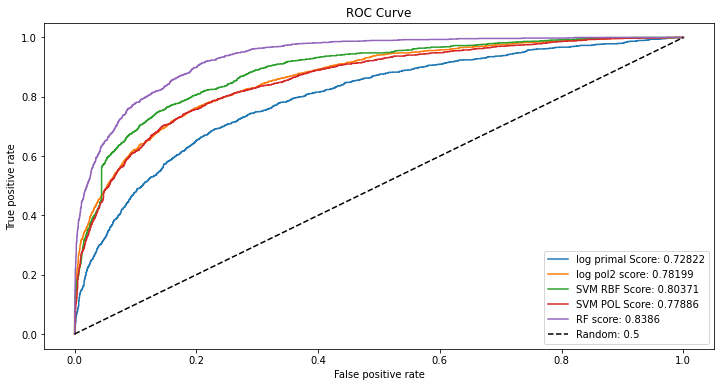

In [60]:
plt.figure(figsize = (12,6), linewidth= 1)
plt.plot(fpr_log_primal, tpr_log_primal, label = 'log primal Score: ' + str(round(auc_log_primal, 5)))
plt.plot(fpr_log_pol2, tpr_log_pol2, label = 'log pol2 score: ' + str(round(auc_log_pol2, 5)))
plt.plot(fpr_SVM_RBF, tpr_SVM_RBF, label = 'SVM RBF Score: ' + str(round(auc_SVM_RBF, 5)))
plt.plot(fpr_SVM_POL, tpr_SVM_POL, label = 'SVM POL Score: ' + str(round(auc_SVM_POL, 5)))
plt.plot(fpr_RF, tpr_RF, label = 'RF score: ' + str(round(auc_RF, 5)))
plt.plot([0,1], [0,1], 'k--', label = 'Random: 0.5')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
#plt.savefig('roc_results_ratios.png')
plt.show()

Based on the analysis, the primary goal is to identify potential churn customers and prevent it by implementing a scheme. Therefore, the focus is on achieving a higher recall for the "churn" class, which is more important than the overall accuracy score. As only 20% of the customers churn, achieving a recall higher than this baseline is already an improvement. The aim is to balance the recall and precision to efficiently allocate resources towards potential churn customers without wasting resources on false positives. The best model for this purpose is the random forest model, with a precision score of 0.91 and a recall score of 0.50 on the "churn" class in the training set. This means that the model can accurately identify 91% of the potential churn customers, out of all the customers that the model predicts will churn. Additionally, the model can identify 50% of all customers who have churned.

This code is performing data transformation and data cleaning on the test dataset (df_test) using the pre-processing pipeline (DfPrepPipeline). The pipeline takes in the test dataset (df_test), and the column names of the training dataset (df_train.columns) as inputs. Additionally, it takes in minVec and maxVec which are the minimum and maximum values of the training dataset, respectively. We use Minimum and Maximum values to normalize and scale the data to ensure that all the values fall between the range on 0 and 1.

The purpose of passing the df_train.columns, minVec, and maxVec as inputs to the pipeline is to ensure that the same data transformations are applied to both the training and test datasets.

The mask function is then used to replace any infinite values in the df_test dataframe with NaN (Not a Number) values. This is necessary because machine learning algorithms cannot handle infinite or NaN values in the data.

Finally, the dropna function is used to remove any rows that contain NaN values from the df_test dataframe. This is necessary because machine learning algorithms cannot handle NaN values in the data.

The shape function is then used to print the number of rows and columns in the cleaned test dataset.

In [37]:
# Make the data transformation for test data
df_test = DfPrepPipeline(df_test,df_train.columns,minVec,maxVec)
df_test = df_test.mask(np.isinf(df_test))
df_test = df_test.dropna()
df_test.shape

C:\Users\hetpa\AppData\Local\Temp\ipykernel_17376\17440563.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_predict[i+'_'+j] = np.where(df_predict[i] == j,1,-1)
C:\Users\hetpa\AppData\Local\Temp\ipykernel_17376\17440563.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_predict[i+'_'+j] = np.where(df_predict[i] == j,1,-1)
C:\Users\hetpa\AppData\Local\Temp\ipykernel_17376\17440563.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

(1911, 17)

In [38]:
print(classification_report(df_test.Exited,  RF.predict(df_test.loc[:, df_test.columns != 'Exited'])))

              precision    recall  f1-score   support

           0       0.85      0.97      0.91      1517
           1       0.77      0.37      0.50       394

    accuracy                           0.85      1911
   macro avg       0.81      0.67      0.70      1911
weighted avg       0.84      0.85      0.82      1911



Test model prediction accuracy on test data

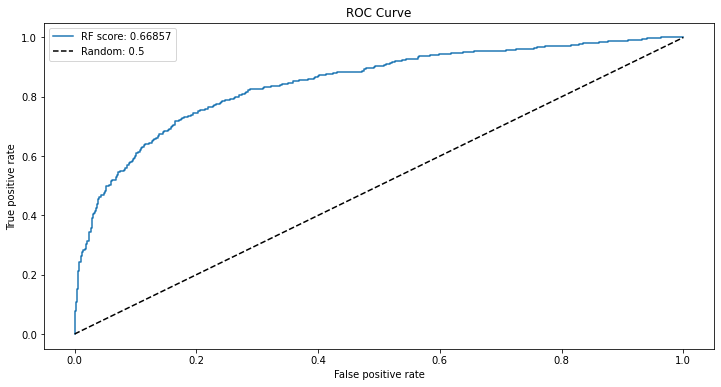

In [39]:
auc_RF_test, fpr_RF_test, tpr_RF_test = get_auc_scores(df_test.Exited, RF.predict(df_test.loc[:, df_test.columns != 'Exited']),
                                                       RF.predict_proba(df_test.loc[:, df_test.columns != 'Exited'])[:,1])
plt.figure(figsize = (12,6), linewidth= 1)
plt.plot(fpr_RF_test, tpr_RF_test, label = 'RF score: ' + str(round(auc_RF_test, 5)))
plt.plot([0,1], [0,1], 'k--', label = 'Random: 0.5')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
#plt.savefig('roc_results_ratios.png')
plt.show()

The given code is used to plot the Receiver Operating Characteristic (ROC) curve and calculate the area under the curve (AUC) score for a random forest classifier model. Here's a brief explanation of what the code does:

get_auc_scores is a function that takes the actual labels (Exited) and predicted labels and probabilities (RF.predict and RF.predict_proba, respectively) for the test set (df_test) and returns the AUC score, false positive rate (fpr), and true positive rate (tpr) values.

The plt module from the Matplotlib library is used to create a figure with a size of 12x6 inches and a line width of 1.

The plt.plot function is used to plot the fpr (x-axis) against the tpr (y-axis) using the values obtained from get_auc_scores. The label for the plot is set to 'RF score: ' concatenated with the rounded value of AUC score.

Another line is plotted using plt.plot to show a dashed line for the random classifier with an AUC score of 0.5.

The plt.xlabel, plt.ylabel, and plt.title functions are used to set the axis labels and the title for the plot.

Finally, the plt.legend function is used to display the legend of the plot, and plt.show function is called to display the plot on the screen.